In [1]:
from yolov5 import detect
from PIL import Image
import os
from glob import glob

import torch
import os
from glob import glob
import numpy as np
torch.manual_seed(777)

# test input 이미지에서 객체 탐지
- 탐지 결과는 json(dict) 

In [2]:
detectedObject_list = detect.object_detection(imgsz=[576],name="test",source="yolov5/hanssem/images/test")

YOLOv5 🚀 700c847 torch 1.9.0+cu102 CUDA:0 (Tesla V100-PCIE-32GB, 32510.5MB)
                                    CUDA:1 (Tesla V100-PCIE-32GB, 32510.5MB)
                                    CUDA:2 (Tesla V100-PCIE-32GB, 32510.5MB)
                                    CUDA:3 (Tesla V100-PCIE-32GB, 32510.5MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs


image 1/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/test/102458.jpg: 576x576 3 closets, Done. (0.055s)
image 2/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/test/102472.jpg: 576x576 1 bed, Done. (0.007s)
image 3/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/test/102473.jpg: 576x576 1 closet, 1 bed, Done. (0.007s)
image 4/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/test/102478.jpg: 576x576 1 bed, Done. (0.006s)
image 5/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/test/103067.jpg: 576x576 1 rug, Done. (0.006s)
image 6/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/test/103926.jpg: 576x576 1 rug, Done. (0.006s)
image 7/952 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_mai

# 탐지한 객체 중에서 임의로 하나 선택

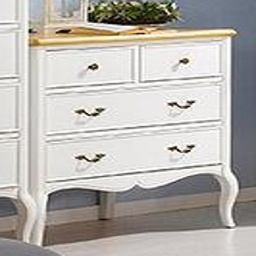

In [3]:
selectObject = detectedObject_list[0]
selectObject_path = selectObject["objectImagePath"]
selectObject_pil = Image.open(selectObject_path)
selectObject_pil

In [4]:
from ImageRetrievalClass import ImageRetrievalClass
retrieval = ImageRetrievalClass("IncepResNet", True, False)
retrieval.readTestSet(selectObject_pil)
retrieval.buildModel()

Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Reading train images
test image shape = (256, 256, 3)
Loading IncepResNet pre-trained model...
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization

In [5]:
X_test = retrieval.testTransform()

Applying image transformer to test images...
 -> X_test.shape = (1, 256, 256, 3)


In [6]:
E_test = retrieval.predictTest(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(retrieval.output_shape_model)))

Inferencing embeddings using pre-trained model...
 -> E_test.shape = (1, 6, 6, 1536)


# 동일 태그를 가진 객체들을 검색대상 pool에서 가져오기
- 추후 mongoDB 쿼리부분으로 바뀌어야 함

In [7]:
jsonFiles_path = glob("./jsonFiles/*.json")


In [8]:
import json
queryed_json_pathList = list()
queryed_jsonList = list()

for path in jsonFiles_path:
    with open(path, "rb") as f:
        jsonFile = json.load(f)

    if jsonFile["tag"] == selectObject["tag"]:
        queryed_json_pathList.append(path)
        queryed_jsonList.append(jsonFile)

In [9]:
queryed_jsonList[0]

{'objectID': 'b3f3e5b3-c378-414c-82cd-6ee1f5150bf2',
 'location': {'xmin': 182, 'ymin': 88, 'xmax': 456, 'ymax': 433},
 'tag': 'closet',
 'objectImagePath': './cropData/train/PngImages/130822_closet_1.png',
 'npyPath': './npyFiles/130822_closet_1.npy',
 'IMG_URL': 'https://image.hanssem.com/hsimg//gds/550/130/130822_A1.jpg'}

# 태그로 쿼리한 json 파일의 npy(E_train)과 E_test를 비교

## json에서 npy가져와서 E_train 만들기

In [10]:
E_train = list()
for json in queryed_jsonList:
    npy = np.load(json["npyPath"])
    E_train.append(npy)


In [11]:
E_train = np.array(E_train)
E_train.shape

(1550, 6, 6, 1536)

In [12]:
retrieval.output_shape_model

(6, 6, 1536)

In [13]:

E_train_flatten = E_train.reshape((-1, np.prod(retrieval.output_shape_model)))
E_test_flatten.shape

(1, 55296)

In [14]:
calculator = retrieval.similarityCalculator(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


## 쿼리 결과의 pool 생성

In [15]:
retrieval_imagePool = [Image.open(json["objectImagePath"]) for json in queryed_jsonList]



## Retrieval

In [16]:
retrieval.retrieval(E_test_flatten=E_test_flatten, calculator=calculator, retrieval_imagePool=retrieval_imagePool )

Performing image retrieval on test images...
